In [90]:
using LinearAlgebra, Pkg, Revise, Plots, QuantumOptics, OMEinsum, CUDA, Zygote, StatsBase

In [36]:
using Qutee
using Qutee.QuantumInfo.Optimization: kraus2stiefel, stiefel2kraus

# Universal control of a Harmonic Oscillator

In the following we characterize a simulated process of a SNAP + Displacement operation of a harmonic oscillator.

Essentially, we perform Wigner tomography via Riemannian optimization.

We select a size for the Fock basis of $N=64$. A coherent probe state undergoes the process, and we measure it using a displaced parity operator.
We then recover the process from the measurement data.

In [9]:
size_basis = 64
b = FockBasis(size_basis-1)

a_hat = destroy(b);

In [10]:
a = coherentstate(b, 4);

Create all the operations and states:
- Parity operator
- Wigner displacment+parity operator
- Measurement operators via Wigner
- All probe states
- All measurement data

In [28]:
# Resolution of Wigner measurement
zs = LinRange(-3,3,30)

betas = zs' .* ones(length(zs)) + ones(length(zs))' .* zs * im

parity_op = [(-1)^i * dm(fockstate(b,i)) for i in 0:size_basis-1] |> sum

function wigner_op(beta)
	dis = displace(b, beta)
	A = dis * parity_op * dis'
	mop = A * 2 / π
	return mop
end

measurements = [x.data for x in wigner_op.(betas)]
m_ops = stack(measurements) |> cu;

all_probes = [dm(fockstate(b,i)) for i in 1:size_basis-1];
all_probes_cu = [p.data for p in all_probes] |> stack |> cu;


In [29]:
Ham = (a_hat' * a_hat)^2
kappa = π/3

thetas = [π/2, π/2, -π/2, -π/2, π/2, π/2]
# Extend thetas to the desired length N with zeros.
thetas = vcat(thetas, zeros(size_basis - length(thetas)))
SNAP = displace(b,2).data * diagm(exp.(1im * thetas)) * displace(b,-2).data
SNAP = reshape(SNAP, (size_basis,size_basis,1));

In [54]:
function simulate(probe)
	U * probe * U'
	Qutee.apply(probe, SNAP)
end

function apply_batch(op, rhos)
	op_conj = conj(op)
	@ein c[i, k, n, m] := rhos[i, j, m] * op_conj[k, j, n]
	@ein d[i, k, m] := op[i, j, n] * c[j, k, n, m]
	return d
end

function measure_batch(meas, rho)
	@ein c[i,k,n,m] := meas[i,j,m,n] * rho[j,k]
	@ein out[n,m] := c[i,i,n,m]
	return out |> real
end

function measure_batch_all(meas, rho)
	@ein c[i,k,n,m,p] := meas[i,j,m,n] * rho[j,k,p]
	@ein out[n,m,p] := c[i,i,n,m,p]
	return out |> real
end

function model_partial(K, probes, basis)
    probe_prime = apply_batch(K, probes)
    data = measure_batch_all(basis, probe_prime)
    return data
end

model_partial (generic function with 1 method)

In [31]:
targets = apply_batch(SNAP|>cu, all_probes_cu);
measure_data = measure_batch_all(m_ops, targets) |> cu;

## Optimize

Perform stochastic gradient descent to fit a process

In [32]:
function loss(K)
	rho = apply_batch(K, all_probes_cu)
	data = measure_batch_all(m_ops, rho)
	norm(measure_data .- data)
end

loss (generic function with 1 method)

In [152]:
k = 2
adam = QuantumInfo.Optimization.AdamCayley(QuantumInfo.rand_channel(CuArray, k, size_basis); l=0.4, β1=0.9, β2=0.999)
batch_size = 25
history = []
for e in 1:50
    for b in 1:30
        c1 = sample(1:size(all_probes_cu, 3), batch_size; replace=false)
        c2 = sample(1:size(m_ops, 3), batch_size; replace=false)

        function f(K)
            out = model_partial(K, all_probes_cu[:, :, c1], m_ops[:, :, c2, c2])
            res = out - measure_data[c2, c2, c1]
            return sum(res .^ 2)
        end

        K = adam.X |> stiefel2kraus
        grad = Zygote.gradient(x -> f(x), K)[1]
        grad = kraus2stiefel(grad)
        QuantumInfo.Optimization.step!(adam, grad)
    end
    K = adam.X |> stiefel2kraus
    push!(history, loss(K))
end

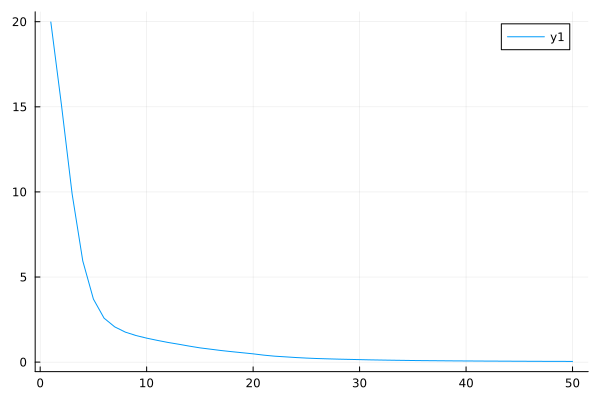

In [155]:
plot(history, fmt=:png)

In [158]:
# Out final fitted operator

opt_K = adam.X |> stiefel2kraus;

In [190]:
# Apply all our probe states through the fitted operator

output_states = apply_batch(opt_K, all_probes_cu);

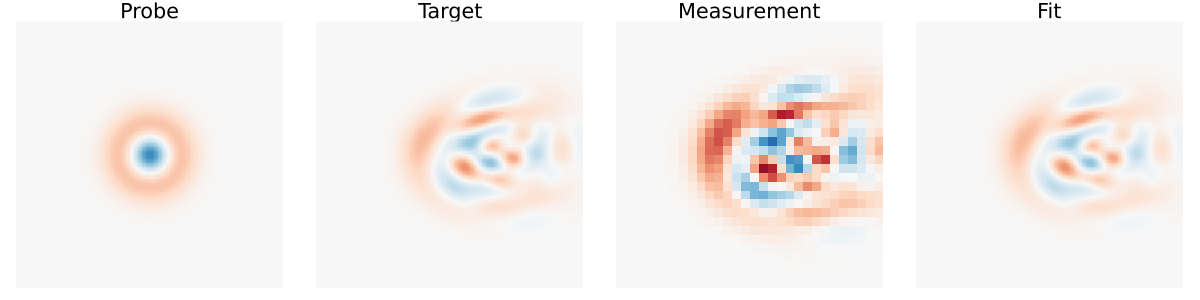

In [189]:
ζ = 5
xs = LinRange(-ζ,ζ, 200)
colors = cgrad(:RdBu, rev=true)

p1 = heatmap(xs,xs,wigner(Operator(b, all_probes_cu[:,:,1]|>Array), xs,xs)|>permutedims, color=colors, aspect_ratio=:equal, axis=([], false), colorbar=false, clim=(-0.5,0.5))
p2 = heatmap(xs,xs,wigner(Operator(b, targets[:,:,1]|>Array), xs,xs)|>permutedims, color=colors, aspect_ratio=:equal, axis=([], false), colorbar=false, clim=(-0.5,0.5))
p3 = heatmap(zs,zs,measure_data[:,:,1]|>Array|>permutedims, color=colors, aspect_ratio=:equal, axis=([], false), colorbar=false, clim=(-0.5,0.5))
p4 = heatmap(xs,xs,wigner(Operator(b, output_states[:,:,1]|>Array), xs,xs)|>permutedims, color=colors, aspect_ratio=:equal, axis=([], false), colorbar=false, clim=(-0.5,0.5))


title!(p1, "Probe")
title!(p2, "Target")
title!(p3, "Measurement")
title!(p4, "Fit")

plot(p1,p2,p3,p4,  layout=(1, 4), size=(1200, 300), fmt=:png)